#Welcome to the Stereo Vision Workshop!
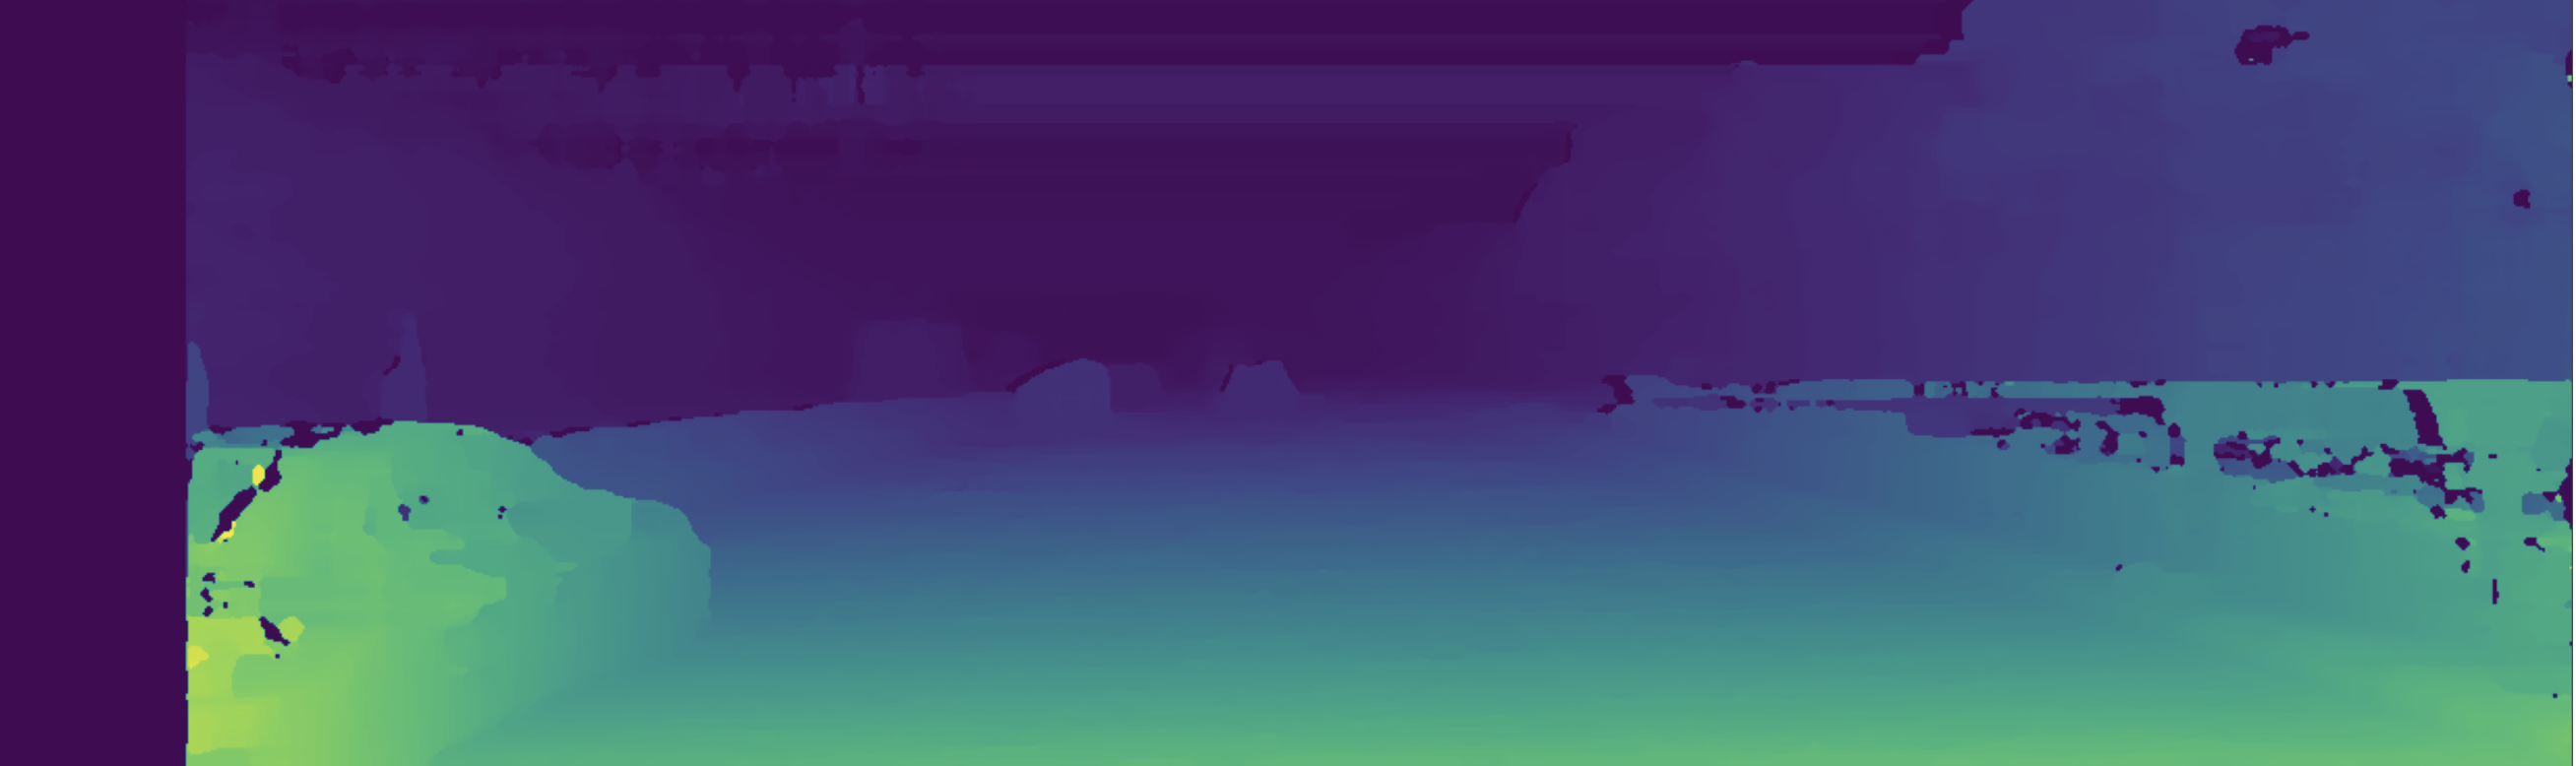


In this workshop, you will learn:


*   How to create a disparity map
*   How to use 3D Projections to estimate 3D coordinates of obstacles
*   How to create a 3D Point Cloud from Stereo Images

For that, we will do it in several parts:


1.   **Load the images.**<p>
There are 4 images: 3 coming from the KITTI VISION BENCHMARK SUITE and 1 coming from my own Stereo Camera.

2.   **Create a Disparity Map**<P>
Use the algorithms we've learned such as Stereo BM and Stereo SGBM to try and build a disparity map!

3.   **Get the Calibration Parameters** <p> 
Use the camera calibration workshop or the calibration files provided to load the matrices.

4.   **Compute the Depth Map**<p>
Use these matrices and the disparity to build a depth map.

5.   **Find Obstacles in 3D**<p>
Use an obstacle detection algorithm and mix it with the depth map to get the distances of each obstacle.

6.   **Build a 3D Point Cloud**<p>
Something we can also do is to build a 3D Point Cloud! I'll show you how!

## Imports & Colab Sync

Start by importing libraries and linking your Google Colab

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/Think Autonomous/SDC Course/Stereo Vision")
!ls

## Additional Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import glob

# Step 1 - Load image data

In [ ]:
images_L = sorted(glob.glob("data/left/*.png"))
images_R = sorted(glob.glob("data/right/*.png"))
labels = sorted(glob.glob("data/labels/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

print("There are",len(images_L),"images")
index = 2
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(cv2.imread(images_L[index]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image Left', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(images_R[index]), cv2.COLOR_BGR2RGB))
ax2.set_title('Image Right', fontsize=30)

# Step 2 - Calculate the Disparity Map

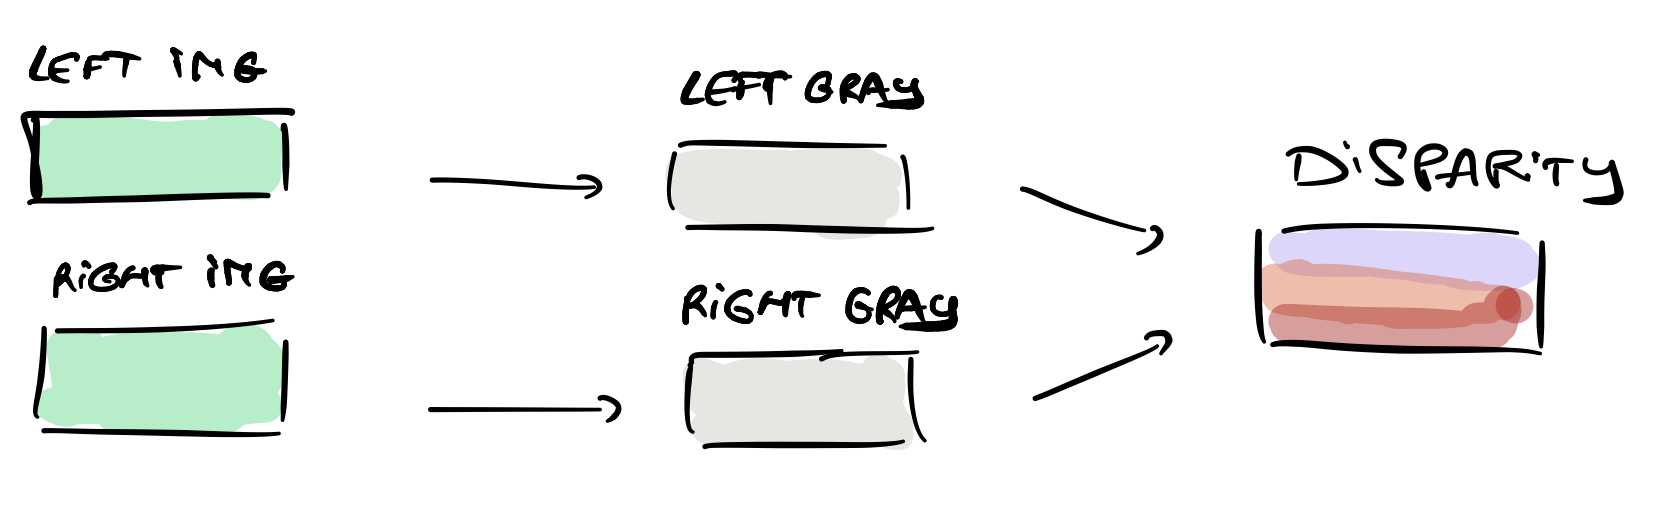

## Compute And Display the Disparity

In [ ]:
def compute_disparity(image, img_pair, num_disparities=6*16, block_size=11, window_size=6, matcher="stereo_sgbm", show_disparity=True):
    """
    Create a Stereo BM or Stereo SGBM Matcher
    Compute the Matching
    Display the disparity image
    Return it 
    """
    if matcher == "stereo_bm":
        new_image = cv2.StereoBM_create(numDisparities=num_disparities,blockSize=block_size)
    elif matcher == "stereo_sgbm":
        '''
        Understand parameters: https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html
        '''
        new_image = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disparities, blockSize=block_size, P1=8 * 3 * window_size ** 2,
            P2=32 * 3 * window_size ** 2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    new_image = new_image.compute(image, img_pair).astype(np.float32)/16
    if (show_disparity==True):
        plt.figure(figsize = (40,20))
        plt.imshow(new_image)
        plt.show()
    return new_image

In [ ]:
"""
NUM_DISPARITIES:
the disparity search range. 
For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities. 
The search range can then be shifted by changing the minimum disparity.
--> The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
"""
num_d = (0,512,16)

"""
BLOCK SIZE: the linear size of the blocks compared by the algorithm. 
Matched block size. It must be an odd number >=1 .
Normally, it should be somewhere in the 3..11 range.
--> Larger block size implies smoother, though less accurate disparity map. 
--> Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.
"""
b_s = (1,19,2)

"""
WINDOW SIZE: 
Default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
"""
window_s = (1,13,2)

"""
MIN DISPARITY
min: Minimum possible disparity value. 
Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
max: has to be dividable by 16 f. E. HH 192, 256, default:
#
"""

In [ ]:
#Reading the Left Images
img_left = cv2.imread(images_L[index]) #OpenCV reads in BGR
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
# Reading the right Images
img_right = cv2.imread(images_R[index]) #OpenCV reads in BGR
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

In [ ]:
disparity_left = interactive(compute_disparity, image=fixed(img_left_gray), img_pair = fixed(img_right_gray), num_disparities=num_d, block_size=b_s, window_size=window_s, matcher=["stereo_sgbm", "stereo_bm"])
display(disparity_left)

In [ ]:
disparity_right = compute_disparity(img_right_gray, img_pair=img_left_gray, num_disparities=disparity_left.kwargs["num_disparities"], block_size=disparity_left.kwargs["block_size"], window_size=disparity_left.kwargs["window_size"], matcher=disparity_left.kwargs["matcher"])
disparity_left = disparity_left.result

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(disparity_left,  cmap="CMRmap_r") # or CMRmap_r 
ax1.set_title('Disparity Left', fontsize=30)
ax2.imshow(disparity_right, cmap="CMRmap_r")
ax2.set_title('Disparity Right', fontsize=30)

#cv2.imwrite("output/disparity.png",disparity_left)

### Analysis, what is a disparity map?

In [ ]:
squared = disparity_left.copy()

cv2.rectangle(squared, pt1=(400,100), pt2=(800,300), color=(255,0,0), thickness=10)
plt.imshow(squared, cmap="CMRmap_r")

print(disparity_left[100:300, 400:800])

The disparity map is the size of the image.<p>
At the location of each pixel, you get the distance in pixel to travel to get the correspondance in the other image.<p>

*   Objects that are far away are smaller in pixels, and the disparity value will be lower
*   Close objects will appear at different angles and thus need a higher disparity value



**From now on, we'll only focus on the image "disparity left".**

#Step 3 - Get Projection Matrices

In [ ]:
print("Calibration file for image: ", open(calib_files[index]))
print(open(calib_files[index]).read())

The following lines will help us parse the dataset to collect desired information.

Note: We are skipping P0 and P1 as they represent grayscale data.

In [ ]:
def get_calibration_parameters(file):
    with open(file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == 'P2':
                p_left = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:2] == 'P3':
                p_right = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:7] == 'R0_rect':
                p_ro_rect = np.array(line[9:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_velo_to_cam':
                p_velo_to_cam = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_imu_to_velo':
                p_imu_to_velo = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
    return p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo

p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

np.set_printoptions(precision=5)
print("Left P Matrix")
print(p_left)
print("Right P Matrix")
print(p_right)
print("RO to Rect Matrix")
print(p_ro_rect)
print("Velodyne to Camera Matrix")
print(p_velo_to_cam)
print("IMU to Velodyne Matrix")
print(p_imu_to_velo)

# Step 4 - Compute the Depth Map

A depth map is a map that contains, for each pixel, the depth information.<p>
**How to get depth information?**

From our formulas, we defined the following:
![](https://miro.medium.com/max/1152/0*jToKsSZEjNhKaV9S.png) <p>


It's clear now... We have:<p>
*   The focal length, f
*   The baseline, b
*   The disparity value, for each pixel

👉 The depth map is a map that contains Z for each pixel



In [ ]:
def decompose_projection_matrix(p):    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3] # Back from homogeneous
    return k, r, t

# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

In [ ]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    # Get the focal length from the K matrix
    f = k_left[0, 0]
    # Get the distance between the cameras from the t matrices (baseline)
    b = abs(t_left[0] - t_right[0]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)
    # Calculate the depths 
    depth_map[:] = f * b / disp_left[:]
    return depth_map

# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disparity_left, k_left, t_left, t_right)
depth_map_right = calc_depth_map(disparity_right, k_right, t_right, t_left)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(depth_map_left,cmap='flag') # or flag
ax1.set_title('Depth Left', fontsize=30)
ax2.imshow(depth_map_right,cmap='flag') # or flag
ax2.set_title('Depth Right', fontsize=30)

# Step 5 - Find the Bounding Boxes

In [ ]:
!python3 -m pip install yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

In [ ]:
from yolov4.tf import YOLOv4
import tensorflow as tf
import time

yolo = YOLOv4(tiny=True)
yolo.classes = "Yolov4/coco.names"
yolo.make_model()
yolo.load_weights("Yolov4/yolov4-tiny.weights", weights_type="yolo")

In [ ]:
def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    # 0 ~ 255 to 0.0 ~ 1.0
    resized_image = resized_image / 255.
    #input_data == Dim(1, input_size, input_size, channels)
    input_data = resized_image[np.newaxis, ...].astype(np.float32)

    candidates = yolo.model.predict(input_data)

    _candidates = []
    result = img.copy()
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        #candidates == Dim(batch, candidates, (bbox))
        candidates = np.concatenate(_candidates, axis=1)
        #pred_bboxes == Dim(candidates, (x, y, w, h, class_id, prob))
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.40)
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        exec_time = time.time() - start_time
        #print("time: {:.2f} ms".format(exec_time * 1000))
        result = yolo.draw_bboxes(img, pred_bboxes)
    return result, pred_bboxes

result, pred_bboxes = run_obstacle_detection(left_img)
plt.imshow(result)
plt.show() 

In [ ]:
cv2.imwrite("output/result_yolo.png", result)

## Let's take a minute and analyze YOLOv4 output

In [ ]:
h, w, _ = img_left.shape
testing_box = pred_bboxes[0]
print("original box", testing_box)
print("center_x:",testing_box[0]*w)
print("center_y",testing_box[1]*h)
print("width:", testing_box[2]*w)
print("height:",testing_box[3]*h)

In [ ]:
def find_distances(depth_map, pred_bboxes, img, method="center"):
    """
    Go through each bounding box and take a point in the corresponding depth map. 
    It can be:
    * The Center of the box
    * The average value
    * The minimum value (closest point)
    * The median of the values
    """
    depth_list = []
    h, w, _ = img.shape
    for box in pred_bboxes:
        x1 = int(box[0]*w - box[2]*w*0.5) # center_x - width /2
        y1 = int(box[1]*h-box[3]*h*0.5) # center_y - height /2
        x2 = int(box[0]*w + box[2]*w*0.5) # center_x + width/2
        y2 = int(box[1]*h+box[3]*h*0.5) # center_y + height/2
        #print(np.array([x1, y1, x2, y2]))
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if method=="closest":
            depth_list.append(obstacle_depth.min()) # take the closest point in the box
        elif method=="average":
            depth_list.append(np.mean(obstacle_depth)) # take the average
        elif method=="median":
            depth_list.append(np.median(obstacle_depth)) # take the median
        else:
            depth_list.append(depth_map[int(box[1]*h)][int(box[0]*w)]) # take the center
    return depth_list

depth_list = find_distances(depth_map_left, pred_bboxes, img_left, method="center")
print(depth_list)

In [ ]:
def add_depth(depth_list, result, pred_bboxes):
    h, w, _ = result.shape
    res = result.copy()
    for i, distance in enumerate(depth_list):
        cv2.putText(res, '{0:.2f} m'.format(distance), (int(pred_bboxes[i][0]*w - pred_bboxes[i][2]*w*0.2),int(pred_bboxes[i][1]*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)    
    return res

res = add_depth(depth_list, result, pred_bboxes)

plt.figure(figsize = (40,20))
plt.imshow(res)
#cv2.imwrite("output/result.png", cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## Compare with the Ground Truth (Labels)

In [ ]:
def ground_truth_display(img_label, index):
    with open(labels[index], 'r') as f:
            fin = f.readlines()
            for line in fin:
                if line.split(" ")[0] != "DontCare":
                    #print(line)
                    x1_value = int(float(line.split(" ")[4]))
                    y1_value = int(float(line.split(" ")[5]))
                    x2_value = int(float(line.split(" ")[6]))
                    y2_value = int(float(line.split(" ")[7]))
                    distance = float(line.split(" ")[13])
                    cv2.rectangle(img_label, (x1_value, y1_value), (x2_value, y2_value), (0,205,0), 10)
                    cv2.putText(img_label, str(distance), (int((x1_value+x2_value)/2),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)    
    return img_label

img_label = img_left.copy()
img_label = ground_truth_display(img_label, index)
plt.figure(figsize=(20,40))
plt.imshow(img_label)
plt.show()


# The Full Pipeline

In [ ]:
def pipeline (img_left, img_right, p_left, p_right):
    "For a pair of 2 Calibrated Images"
    #Reading the Left Images
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    # Reading the right Images
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    # Compute the Disparity Map
    disparity = compute_disparity(img_left_gray, img_pair=img_right_gray, num_disparities=112, block_size=6, window_size=5, matcher="stereo_sgbm", show_disparity=False)
    # Get the Calibration Parameters
    k_left, r_left, t_left = decompose_projection_matrix(p_left)
    k_right, r_right, t_right = decompose_projection_matrix(p_right)
    # Compute the Depth Map
    depth_map = calc_depth_map(disparity, k_left, t_left, t_right)
    # Run obstacle detection in 2D
    result, pred_bboxes = run_obstacle_detection(img_left)
    # Find the Distance
    depth_list = find_distances(depth_map, pred_bboxes, img_left)
    # Final Image
    final = add_depth(depth_list, result, pred_bboxes)
    return final

In [ ]:
index  = 5
img_left = cv2.imread(images_L[index])
img_right = cv2.imread(images_R[index])
p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

final = pipeline(img_left, img_right, p_left, p_right)
plt.figure(figsize = (40,20))
plt.imshow(final)
plt.show()

In [ ]:
ground_truth = ground_truth_display(img_left, index)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(40,20))
ax1.set_title("You")
ax1.imshow(final)
ax2.set_title("The program we told you not to worry about")
ax2.imshow(ground_truth)
plt.show()

## 3D Bounding Boxes

We have the distance!
As you noticed, it's very sensitive to:

*   The Calibration Parameters (Intrinsics & Extrinsics)
*   The Setup (Baseline, ...)
*   The Stereo Matching Algorithm (SGBM here)

In [ ]:
"""
I'm cloning this awesome repository for 3D Bounding Boxes.
This will be used to get our ground truth.
License is open to use.
"""

#!git clone https://github.com/darylclimb/cvml_project.git


import sys

#!pip install mayavi
#!pip install pyqt5
#!mv cvml_project/projections/lidar_camera_projection .
#!rm -rf cvml_project
#print(cv2.__version__)
!ls
!python3 lidar_camera_projection/lidar_camera_project.py --img "/content/drive/My Drive/Think Autonomous/SDC Course/Stereo Vision/data/left/000007.png" --calib "/content/drive/My Drive/Think Autonomous/SDC Course/Stereo Vision/data/calib/000007.txt" --label "/content/drive/My Drive/Think Autonomous/SDC Course/Stereo Vision/data/labels/000007.txt" --bin "/content/drive/My Drive/Think Autonomous/SDC Course/Stereo Vision/data/bin/000007.bin"

# Build a 3D Point Cloud (3D Reconstruction)

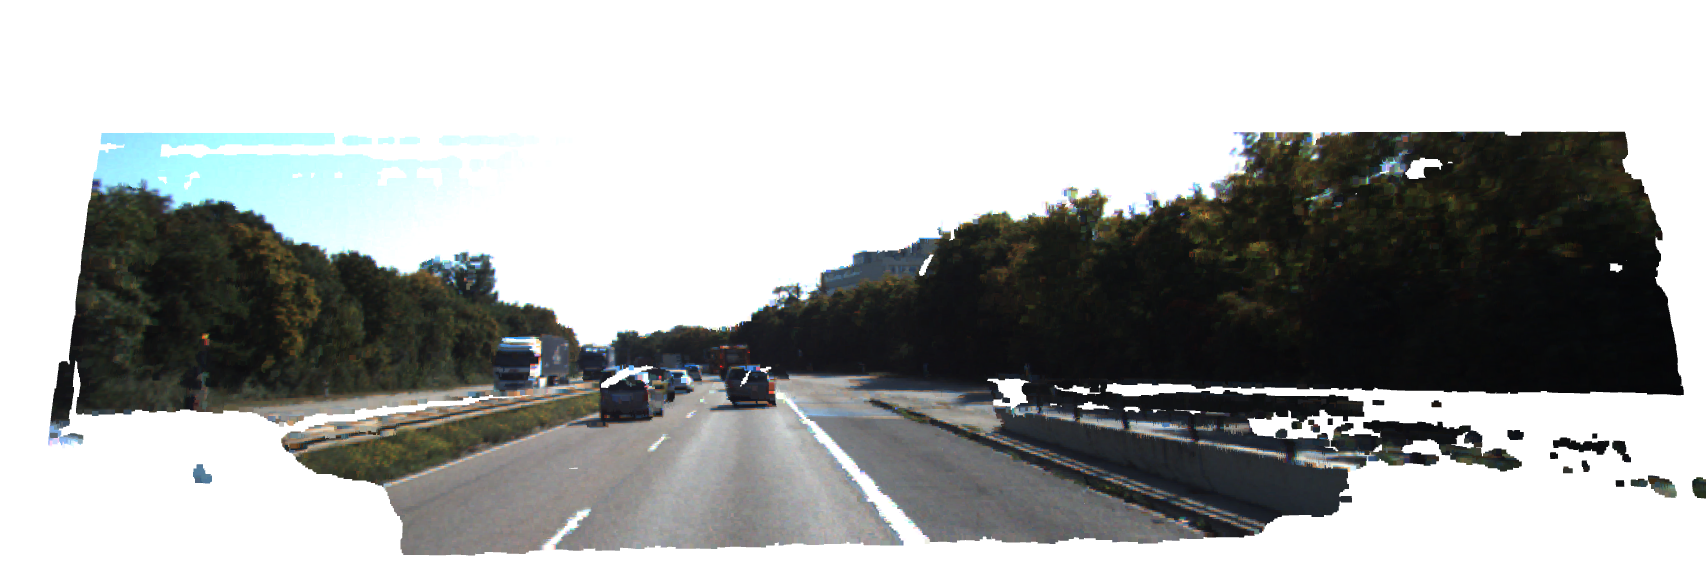

OpenCV uses the Q Matrix is used to get a 3D Point Cloud.
If you've done the calibration notebook, you saw this Q matrix as "disparity to depth".

**Structure of the Q Matrix:**<p>
![](https://answers.opencv.org/upfiles/15222662547364629.png)

It is obstained through stereo calibration, in particular, the function
```
Q = np.zeros(4,4)
cv2. stereoRectify (cameraMatrixLeft, CameraMatrixRight, distortion_coefficients_left, distortion_coefficients_right, image_size, R, T, R1, R2, P1, P2, Q)
```

Then, StereoRectify modifies the Q matrix.

**It then can be used the following:**<p>
![](https://answers.opencv.org/upfiles/1522266963686882.png)


In [ ]:
# Calculate depth-to-disparity
cam1 = p_left[:,:3] # left image - P2
cam2 = p_right[:,:3] # right image - P3

print(p_left)
print(cam1)

Tmat = np.array([0.54, 0., 0.]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)

Q = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = Q);

print("Disparity To Depth")
print(Q)

In [ ]:
points = cv2.reprojectImageTo3D(disparity_left.copy(), Q)


#reflect on x axis

reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)


#extract colors from image
#img_left_color = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
#colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
img_left = cv2.imread(images_L[index])
colors = cv2.cvtColor(img_left.copy(),cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = disparity_left > disparity_left.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
#idx = np.fabs(out_points[:,0]) < 4.5
#out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
#out_colors = out_colors[idx]

In [ ]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

file_name = "output/out"+str(index)+".ply"
write_ply(file_name, out_points, out_colors)


#Video Recognition

If you want something really impressive to recruiters, the best thing to have is a video.

On the dataset: http://www.cvlibs.net/datasets/kitti/raw_data.php

## Do it on other images:<p>
Under "Raw Data", you can get access to the videos.
Take rectified images, download the folder, and import it here.
Then, start to run the video.

In [ ]:
left_video = glob.glob("data/video/left/*.png")
right_video = glob.glob("data/video/right/*.png")

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline(left_img, right_img, p_left, p_right))

out = cv2.VideoWriter('output/out.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()